In [1]:
import math                                                 # basic calculations like square root
import numpy as np                                          # arrays and matrix math
import scipy.stats as st                                    # statistical methods
import matplotlib.pyplot as plt                             # for plotting
import geostatspy.GSLIB as GSLIB                            # GSLIB utilies, visualization and wrapper
import seaborn as sns
import pandas as pd                                         # DataFrames
import pandas.plotting as pd_plot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours
from sklearn import metrics                                 # measures to check our models
from sklearn.model_selection import cross_val_score         # cross validation methods
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.ensemble import BaggingRegressor   
from sklearn.ensemble import RandomForestRegressor          # random forest method

In [2]:
df = pd.read_csv("03_RandomForest.csv")                    # read a .csv file in as a DataFrame

In [3]:
# ---------------- Physics-based features dropping: Potential Multicollinearity = PMCL
df_1 = df
df_1 = df_1.drop("g_Shc_EF (Gross)",axis=1) # PMCL with SPH: Hydrocarbon Saturation 
df_1 = df_1.drop("g_POR-TH (Gross)",axis=1) # PMCL with SPH: Porosity*Thickness 
df_1 = df_1.drop("g_Av_Porosity_EF (Cut-off)",axis=1) # PMCL with SPH: porosity

df_1 = df_1.drop("g_EF Gross Thickness map (Corelab + NVOct3)",axis=1) # PMCL: Growth = Upper + Lower
df_1 = df_1.drop("GOR",axis=1)       # PMCL with Oil EUR and Gas EUR
df_1 = df_1.drop("API",axis=1) # PMCL with oil type
df_1 = df_1.drop("g_Av_Brittleness_Index_Core Geomechanic",axis=1)  # PMCL with Young's Modulus and Poission Ratio

df_1 = df_1.drop("c_calc_Total Proppant (lbs)",axis=1)  # Linear with Proppant per foot
df_1 = df_1.drop("c_stage",axis=1)                      # Linear with Proppant per foot

# ---------------- drop well lacking of selected features ----------------
df_1.drop(df_1[df_1['g_shcPhiH_EF_(Cut-off) ']==0].index ,inplace=True)
df_1.drop(df_1[df_1['g_Av_Compressive Strength_Static (kpsi)']==0].index ,inplace=True)
df_1.drop(df_1[df_1['c_clat']==0].index ,inplace=True)
df_1.drop(df_1[df_1['c_api (Oil stream)']==0].index ,inplace=True)

# # # # # # Comparing apple with apple, # enforcing 20 perf per cluster and  15 stage, that are majority

df_1.drop(df_1[df_1["c_calc_Perfclusters"]!=20].index ,inplace=True) 
df_1 = df_1.drop("c_calc_Perfclusters",axis=1)  # removing 'perf per cluster' feature

df_1.drop(df_1[df_1["c_calc_FracStages"]!=15].index ,inplace=True)   
df_1 = df_1.drop("c_calc_FracStages",axis=1)    # removing 'number of stages' feature

df_1.dropna(inplace=True)                       # drop wells with no depth feature :c_well depth = nan

# ---------------- drop well with Super High EUR ----------------
df_1.drop(df_1[df_1["Gas_EUR"] >4.5e6].index ,inplace=True)   

# ---------------- Horizontal well azimuth ----------------
# drop wells with no azimuth feature
df_1.drop(df_1[df_1["c_azimuth"] == 0].index ,inplace=True)   # Azimuth 
# convert azimuth of horizontal well to a deviated azimuth from assumed Shmin
# Base on distribution of azimuth, assuming 150 degree and 330 degree as Shmin
Shmin_1 = 150
Shmin_2 = 330
for idx, row in df_1.iterrows():
    if  df_1.loc[idx,'c_azimuth'] > 70 and df_1.loc[idx,'c_azimuth'] < 250:
        df_1.loc[idx,'c_azimuth'] = abs(df_1.loc[idx,'c_azimuth']-Shmin_1)
    else:
        if df_1.loc[idx,'c_azimuth'] < 70:
            df_1.loc[idx,'c_azimuth'] += 360
            df_1.loc[idx,'c_azimuth'] = abs(df_1.loc[idx,'c_azimuth']-Shmin_2)
        else:
            df_1.loc[idx,'c_azimuth'] = abs(df_1.loc[idx,'c_azimuth']-Shmin_2)         
df_1.shape

df_1 = df_1.drop("Operator",axis=1)
df_1 = df_1.drop("Spud Time",axis=1)

In [4]:
df_1.rename(columns={"g_TOC_EF": "TOC", "g_av_VRE_Core": "VRE","g_shcPhiH_EF_(Cut-off) ": "SPH", "g_Av_Compressive Strength_Static (kpsi)": "CS","g_Av Youngs Modulus_Static (Mpsi)": "YM",
                   "g_NTG_EF (With Cut-off)": "NTG","g_Pressure_Gradient(psi_ft)": "PG", "g_Av Poisson Ratio )Static)": "PR","g_P50_Gross_UEF": "GH_UEF",
                   "g_P50_Gross_LEF": "GH_LEF", "c_well depth": "WDep","c_clat": "ProppantIntensity", "c_calc_CLAT (ft)": "WLen",
                   "c_azimuth": "DAZM","c_api (Oil stream)" : "API"}, inplace=True)
df_1.count()

x                    474
y                    474
Oil Type             474
TOC                  474
VRE                  474
SPH                  474
CS                   474
YM                   474
NTG                  474
PG                   474
PR                   474
GH_UEF               474
GH_LEF               474
WDep                 474
API                  474
WLen                 474
DAZM                 474
ProppantIntensity    474
Oil_EUR              474
Gas_EUR              474
EUR_BOE              474
dtype: int64

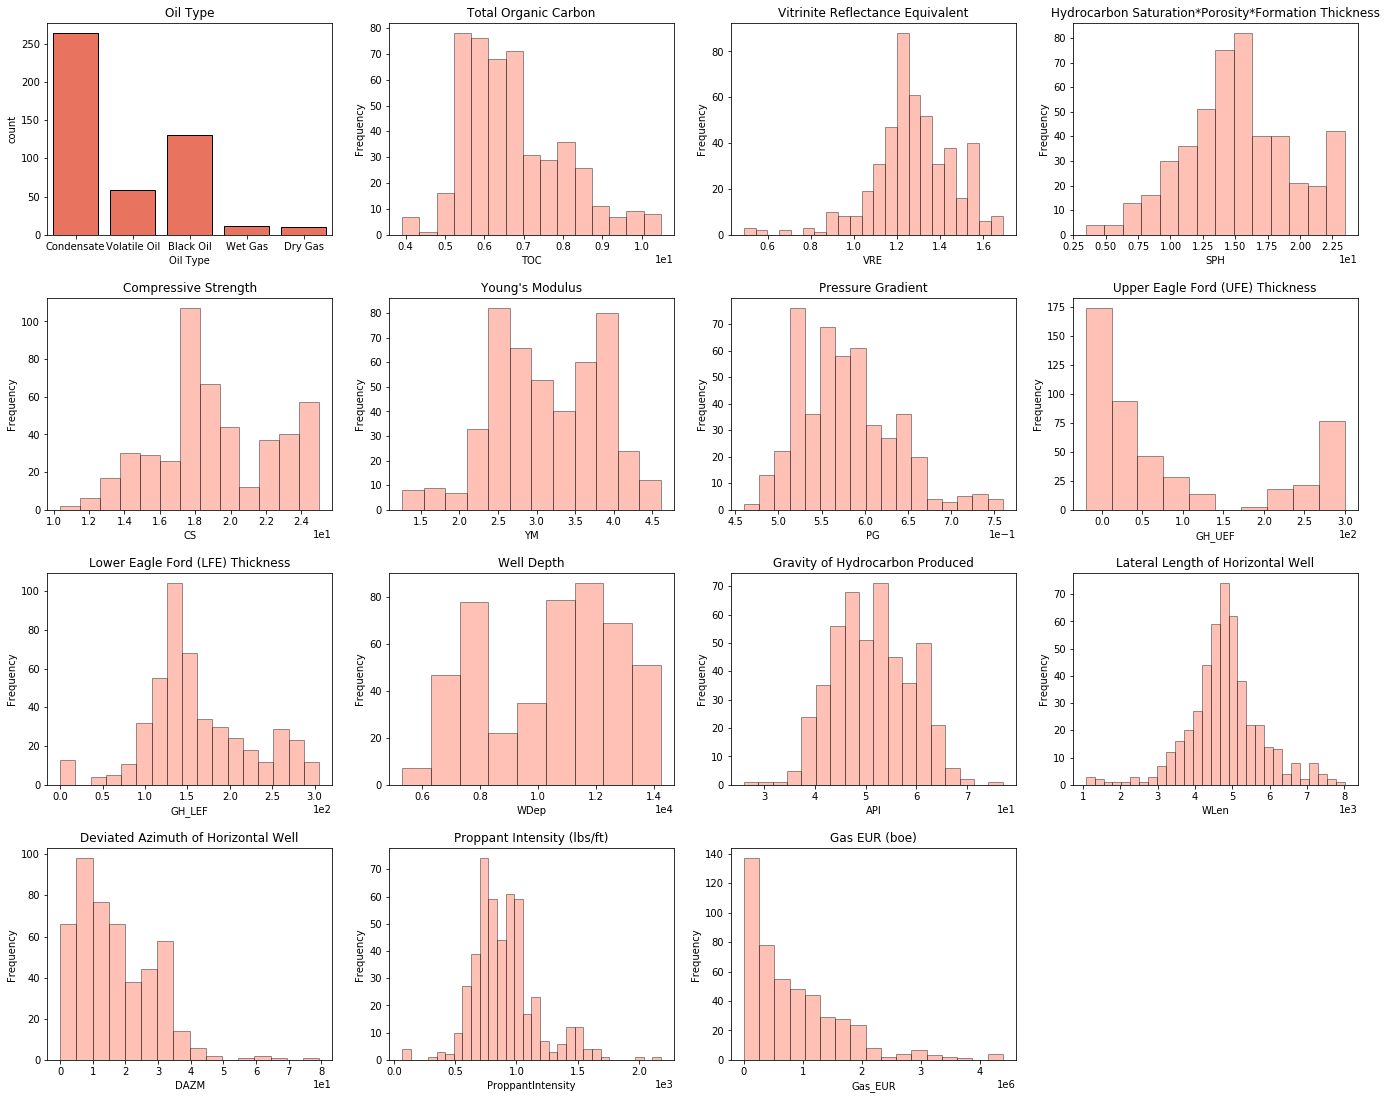

In [5]:
fig = plt.figure(figsize=(7,8))
ax1 = fig.add_subplot(4,4,1);
sns.countplot(df_1['Oil Type'],color='tomato',edgecolor="k")
ax1.set_title('Oil Type',fontsize=12)

def hist_plot(df,feature,title,ax):
    sns.distplot(df[feature],color='tomato',kde=False, ax=ax,hist_kws=dict(edgecolor="k"))
    ax.set_title(title,fontsize=12)
    ax.set_ylabel('Frequency')
    ax.ticklabel_format(axis='x',style='sci', scilimits=(0,0))
 
ax2 = fig.add_subplot(4,4,2);
hist_plot(df_1,'TOC', 'Total Organic Carbon',ax2)
ax2 = fig.add_subplot(4,4,3);
hist_plot(df_1,'VRE', 'Vitrinite Reflectance Equivalent',ax2)
ax2 = fig.add_subplot(4,4,4);
hist_plot(df_1,'SPH', 'Hydrocarbon Saturation*Porosity*Formation Thickness',ax2)
ax2 = fig.add_subplot(4,4,5);
hist_plot(df_1,'CS', 'Compressive Strength',ax2)
ax2 = fig.add_subplot(4,4,6);
hist_plot(df_1,'YM', "Young's Modulus",ax2)
ax2 = fig.add_subplot(4,4,7);
hist_plot(df_1,'PG', 'Pressure Gradient',ax2)
ax2 = fig.add_subplot(4,4,8);
hist_plot(df_1,'GH_UEF', 'Upper Eagle Ford (UFE) Thickness',ax2)
ax2 = fig.add_subplot(4,4,9);
hist_plot(df_1,'GH_LEF', 'Lower Eagle Ford (LFE) Thickness',ax2)
ax2 = fig.add_subplot(4,4,10);
hist_plot(df_1,'WDep', 'Well Depth',ax2)
ax2 = fig.add_subplot(4,4,11);
hist_plot(df_1,'API', 'Gravity of Hydrocarbon Produced',ax2)
ax2 = fig.add_subplot(4,4,12);
hist_plot(df_1,'WLen', 'Lateral Length of Horizontal Well',ax2)
ax2 = fig.add_subplot(4,4,13);
hist_plot(df_1,'DAZM', 'Deviated Azimuth of Horizontal Well',ax2)
ax2 = fig.add_subplot(4,4,14);
hist_plot(df_1,'ProppantIntensity', 'Proppant Intensity (lbs/ft)',ax2)
ax2 = fig.add_subplot(4,4,15);
hist_plot(df_1,'Gas_EUR', 'Gas EUR (boe)',ax2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.6, top=1.8, wspace=0.2, hspace=0.3)
plt.savefig('03_RandomForest_Gas_1_Date_Dist.png', dpi=300,bbox_inches='tight')

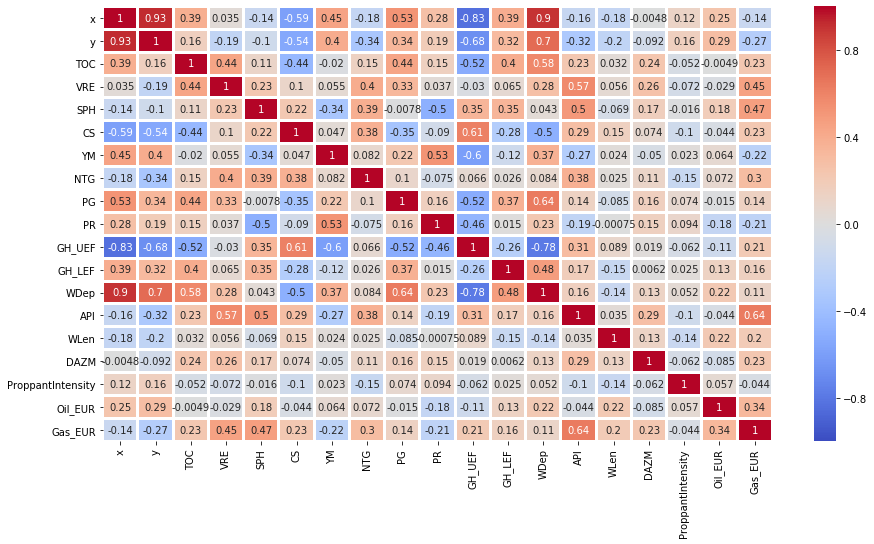

In [6]:
plt.figure(figsize = (15,8))
df_1 = df_1.drop('EUR_BOE',axis=1)
sns.heatmap(df_1.corr(),vmin = -1.0, vmax = 1.0,linewidths=2, cmap="coolwarm",annot=True,)
plt.savefig("03_RandomForest_Gas_1_Date_CorrCoef.png")

In [7]:
df_1.to_csv('03_RandomForest_Gas.csv',index=False)

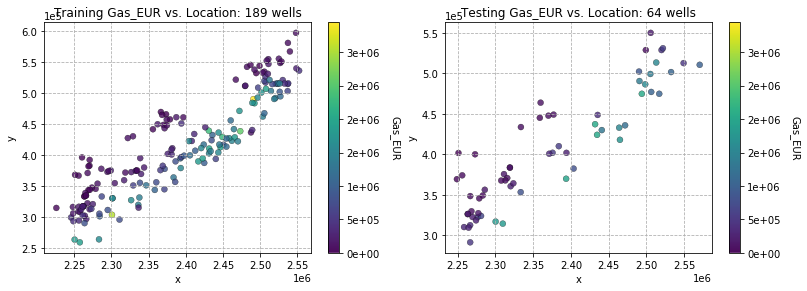

In [8]:
df = pd.read_csv("03_RandomForest_Gas.csv")
df.rename(columns={"Oil Type": "Oil_Type"}, inplace=True)   # Convert categorical data to number
df.Oil_Type.replace({"Black Oil":"1","Volatile Oil":"2","Condensate":"3",
                     "Wet Gas":"4","Dry Gas":"5"}, inplace=True)

df.drop(df[df["x"] < 2.2e6].index ,inplace=True)   
df.describe().transpose()

PARA_1 = 'x';    PARA_2 = 'y';   PARA_3 = 'Gas_EUR'
prodmax = np.max(df[PARA_3]);  prodmin = np.min(df[PARA_3])
xmin = np.min(df[PARA_1]); xmax = np.max(df[PARA_1]); 
ymin = np.min(df[PARA_2]); ymax = np.max(df[PARA_2]);

Data_Subset = df; 

seed = 77888

pred_features =[
    'x','y','Oil_Type','TOC','VRE','SPH','CS','YM','PG','GH_UEF',
    'GH_LEF','WDep','API','WLen','DAZM','ProppantIntensity']

# 25% testing data 
x_train,x_test,y_train,y_test = train_test_split(Data_Subset[pred_features],
                                                 Data_Subset[[PARA_3]],test_size=0.25, random_state=seed)
plt.subplot(121)
im = plt.scatter(x_train[PARA_1],x_train[PARA_2],s=None, c=y_train[PARA_3], marker=None, cmap=None, norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Training ' + PARA_3+' vs. Location'+ ': %i wells'%x_train[PARA_2].count()); 
plt.xlabel(PARA_1); plt.ylabel(PARA_2)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
cbar = plt.colorbar(im, orientation = 'vertical',format='%.0e')
cbar.set_label(PARA_3, rotation=270, labelpad=20)
plt.grid(True,linestyle= '--');
plt.subplot(122)
im = plt.scatter(x_test[PARA_1],x_test[PARA_2],s=None, c=y_test[PARA_3], marker=None, cmap=None, norm=None, vmin=prodmin, vmax=prodmax,alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing ' + PARA_3+' vs. Location'+': %i wells'%x_test[PARA_2].count()); 
plt.xlabel(PARA_1); plt.ylabel(PARA_2)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
cbar = plt.colorbar(im, orientation = 'vertical',format='%.0e')
cbar.set_label(PARA_3, rotation=270, labelpad=20)
plt.grid(True,linestyle= '--');

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=0.8, wspace=0.2, hspace=0.4)
plt.savefig('03_RandomForest_Gas_2_DateSplit.png', dpi=300,bbox_inches='tight')

In [9]:
import warnings
warnings.filterwarnings('ignore')

max_num_trees = 200                                  
num_trees = np.linspace(1,max_num_trees,max_num_trees)

max_features = int(round(np.sqrt(len(pred_features))))
max_depth = 20
fit_forests = []; oob_mse = []; oob_score = []; 

index = 1
for num_tree in num_trees:                                 # loop over number of trees in our random forest
    fit_forests.append(RandomForestRegressor(max_depth=max_depth,random_state=seed,n_estimators=int(num_tree),max_features = max_features,n_jobs=-1))
    fit_forests[index-1].fit(X = x_train, y = y_train)
    oob_mse.append( metrics.mean_squared_error(y_test,fit_forests[index-1].predict(x_test)) )
    oob_score.append( metrics.explained_variance_score(y_test,fit_forests[index-1].predict(x_test)) )
    index = index + 1

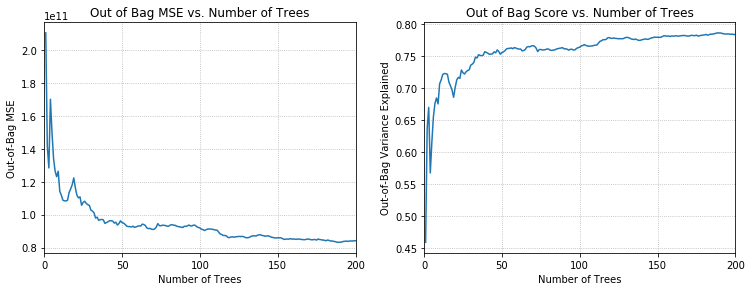

In [10]:
plt.subplot(121)
plt.title('Out of Bag MSE vs. Number of Trees'); 
plt.xlabel('Number of Trees')
plt.ylabel('Out-of-Bag MSE')
plt.plot(num_trees,oob_mse)
plt.xlim(0,max_num_trees); plt.xticks(np.arange(0, max_num_trees+1, 50.0)); plt.grid(linestyle=':')

plt.subplot(122)
plt.title('Out of Bag Score vs. Number of Trees'); 
plt.xlabel('Number of Trees')
plt.ylabel('Out-of-Bag Variance Explained')
plt.plot(num_trees,oob_score)
plt.xlim(0,max_num_trees); plt.xticks(np.arange(0, max_num_trees+1, 50.0)); plt.grid(linestyle=':')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=0.8, wspace=0.22, hspace=0)
plt.savefig("03_RandomForest_Gas_2_HP_NumTree.png", dpi=300,bbox_inches='tight')

In [11]:
import warnings
warnings.filterwarnings('ignore')

max_dep = 50                                  
max_depths = np.linspace(1,max_dep,max_dep)  

num_trees = 200
fit_forests = []; oob_mse = []; oob_score = []; 

index = 1
for max_depth in max_depths:                                  
    fit_forests.append(RandomForestRegressor(max_depth=max_depth,random_state=seed,n_estimators=int(num_tree),max_features = max_features,n_jobs=-1))
    fit_forests[index-1].fit(X = x_train, y = y_train)
    oob_mse.append( metrics.mean_squared_error(y_test,fit_forests[index-1].predict(x_test)) )
    oob_score.append( metrics.explained_variance_score(y_test,fit_forests[index-1].predict(x_test)) )
    index = index + 1

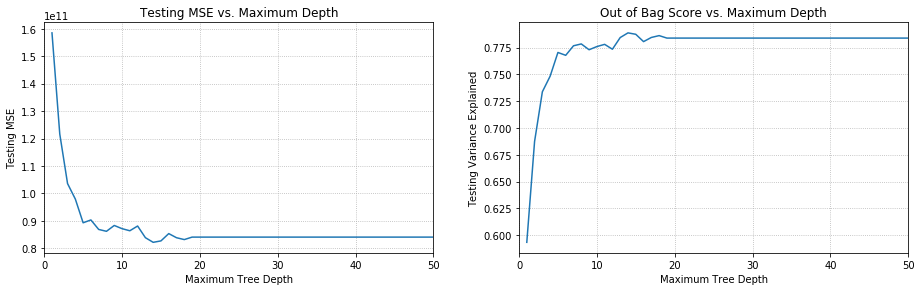

In [12]:
plt.subplot(121)
plt.title('Testing MSE vs. Maximum Depth'); 
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Testing MSE')
plt.plot(max_depths,oob_mse)
plt.xlim(0,max_dep); plt.grid(linestyle=':')

plt.subplot(122)
plt.title('Out of Bag Score vs. Maximum Depth'); 
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Testing Variance Explained')
plt.plot(max_depths,oob_score)
plt.xlim(0,max_dep); plt.grid(linestyle=':')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=0.8, wspace=0.22, hspace=0)
plt.savefig("03_RandomForest_Gas_2_HP_MaxDepth.png", dpi=300,bbox_inches='tight')

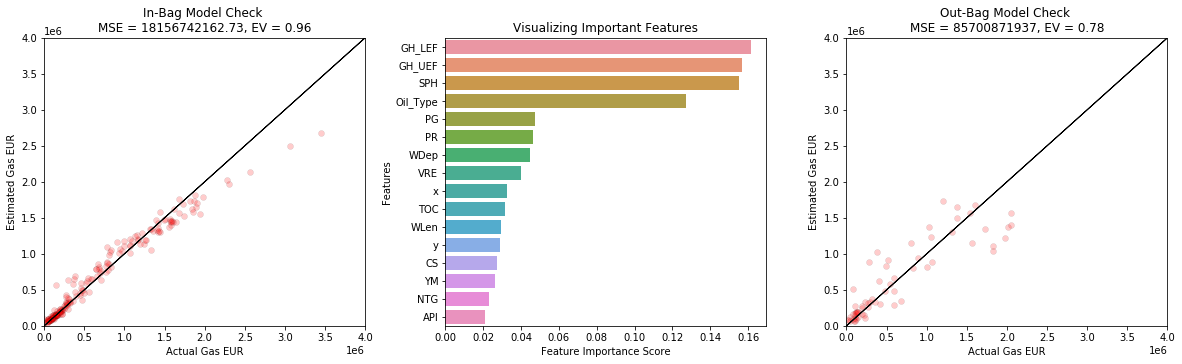

In [13]:
num_tree = 200
max_depth = 20

regressor = RandomForestRegressor(max_depth=max_depth, random_state=76767, n_estimators=num_tree,max_features = max_features,n_jobs=-1)
regressor.fit(X = x_train, y = y_train)      

plt.subplot(131)
y_pred = regressor.predict(x_train)
plt.scatter(y_train[PARA_3],y_pred,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.xlabel('Actual Gas EUR'); plt.ylabel('Estimated Gas EUR')
plt.xlim(0,4e6); plt.ylim(0,4e6)
plt.arrow(0,0,6e7,6e7,width=0.02,color='black',head_length=0.0,head_width=0.0)
MSE = metrics.mean_squared_error(y_train[PARA_3],y_pred)
Var_Explained = metrics.explained_variance_score(y_train[PARA_3],y_pred)
plt.title('In-Bag Model Check \nMSE = %.2f, EV = %.2f' %(round(MSE,2),round(Var_Explained,2)),fontsize=12)
plt.ticklabel_format(style='sci', scilimits=(0,0))

plt.subplot(132)
feature_imp = pd.Series(regressor.feature_importances_,index=Data_Subset.columns[0:16]).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

plt.subplot(133)
y_pred = regressor.predict(x_test)
plt.scatter(y_test[PARA_3],y_pred,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.xlabel('Actual Gas EUR'); plt.ylabel('Estimated Gas EUR')
plt.xlim(0,4e6); plt.ylim(0,4e6)
plt.arrow(0,0,6e7,6e7,width=0.02,color='black',head_length=0.0,head_width=0.0)
MSE = metrics.mean_squared_error(y_test[PARA_3],y_pred)
Var_Explained = metrics.explained_variance_score(y_test[PARA_3],y_pred)
cor = math.sqrt(metrics.r2_score(y_test[PARA_3],y_pred))
plt.title('Out-Bag Model Check \nMSE = %.0f, EV = %.2f' %(round(MSE,2),round(Var_Explained,2)),fontsize=12)
plt.ticklabel_format(style='sci', scilimits=(0,0))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.6, top=1, wspace=0.25, hspace=0)
plt.savefig("03_RandomForest_Gas_3_Final_Result.png", dpi=300,bbox_inches='tight')

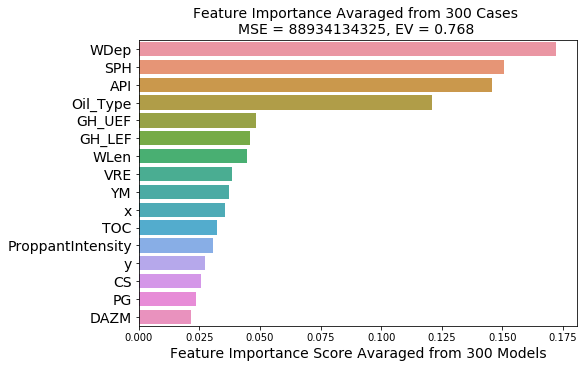

In [14]:
num_tree = 100
max_depth = 20

regressor = RandomForestRegressor(max_depth=max_depth,random_state=76767,n_estimators=num_tree,max_features = max_features,n_jobs=-1)
regressor.fit(X = x_train, y = y_train) 
feature_imp = pd.Series(regressor.feature_importances_,index=x_train.columns[0:16]).sort_values(ascending=False)

cases = 300
MSE = 0
Var_Explained = 0  
for i in range(cases-1):
    regressor = RandomForestRegressor(max_depth=max_depth,random_state=66447+i, n_estimators=num_tree,max_features = max_features,n_jobs=-1)
    regressor.fit(X = x_train, y = y_train) 
    
    y_pred = regressor.predict(x_test)
    MSE += metrics.mean_squared_error(y_test[PARA_3],y_pred)
    Var_Explained += metrics.explained_variance_score(y_test[PARA_3],y_pred)
    
    feature_imp += pd.Series(regressor.feature_importances_,index=x_train.columns[0:16]) 
    
feature_imp=feature_imp.sort_values(ascending=False)
fig = plt.figure(figsize=(8, 5),facecolor='white',constrained_layout=True)
plt.subplot(111)
sns.barplot(x=feature_imp/cases, y=feature_imp.index)
plt.xlabel('Feature Importance Score Avaraged from %d Models'%(cases),fontsize=14)
plt.yticks(fontsize=14)
plt.title("Feature Importance Avaraged from %i Cases \nMSE = %.0f, EV = %.3f "
          %(cases,round(MSE/cases),(Var_Explained/cases)),fontsize=14)

plt.savefig("03_RandomForest_Gas_3_FeatureImportance.png", dpi=300,bbox_inches='tight')

In [15]:
df['EUR_Level'] = np.where(df['Gas_EUR']>=1.5e6, 'High', 'Low') # make a high and low EURuction categorical feature
df.Oil_Type.replace({"1":"BlackOil","2":"VolatileOil","3":"Condensate",
                     "4":"WetGas","5":"DryGas"}, inplace=True)

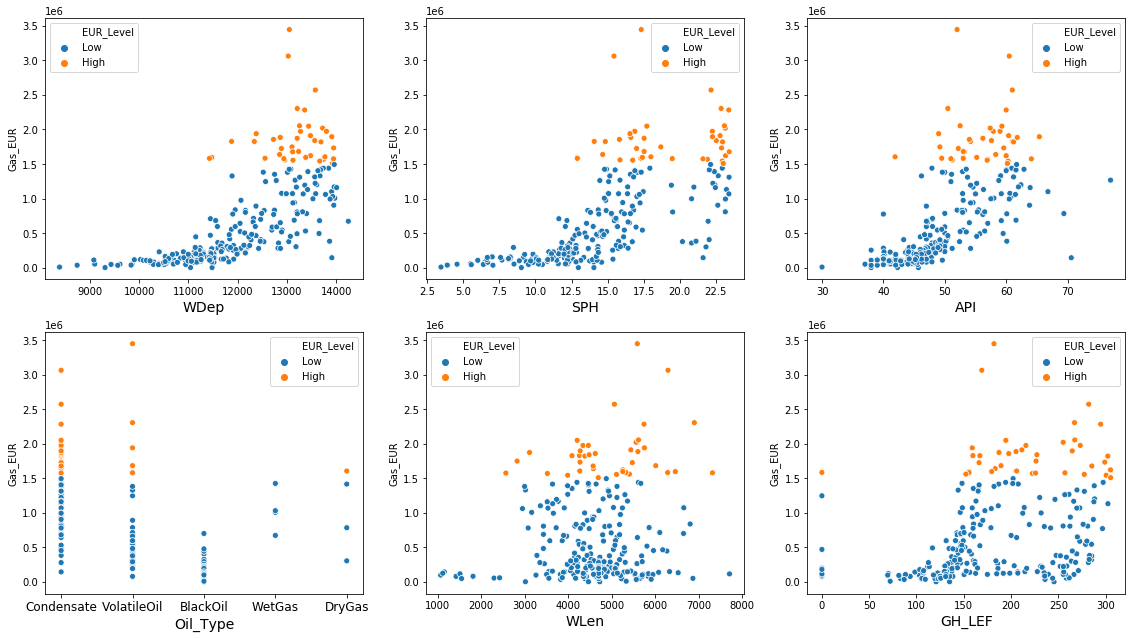

In [16]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(231); ax2 = fig.add_subplot(232); 
ax3 = fig.add_subplot(233); ax4 = fig.add_subplot(234); 
ax5 = fig.add_subplot(235); ax6 = fig.add_subplot(236);

sns.scatterplot(df['WDep'],df['Gas_EUR'],markers='o',hue=df["EUR_Level"], ax=ax1);
sns.scatterplot(df['SPH'],df['Gas_EUR'],markers='o',hue=df["EUR_Level"], ax=ax2);
sns.scatterplot(df['API'],df['Gas_EUR'],markers='o',hue=df["EUR_Level"], ax=ax3);
sns.scatterplot(df['Oil_Type'],df['Gas_EUR'],markers='o',hue=df["EUR_Level"], ax=ax4);
sns.scatterplot(df['WLen'],df['Gas_EUR'],markers='o',hue=df["EUR_Level"], ax=ax5);
sns.scatterplot(df['GH_LEF'],df['Gas_EUR'],markers='o',hue=df["EUR_Level"], ax=ax6);

ax1.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
ax3.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
ax4.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
ax4.tick_params(axis='x', which='major', labelsize=12)
ax5.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
ax6.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
ax1.set_xlabel('WDep',fontsize=14)
ax2.set_xlabel('SPH',fontsize=14)
ax3.set_xlabel('API',fontsize=14)
ax4.set_xlabel('Oil_Type',fontsize=14)
ax5.set_xlabel('WLen',fontsize=14)
ax6.set_xlabel('GH_LEF',fontsize=14)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=2, wspace=0.2, hspace=0.2)
fig.savefig("03_RandomForest_Gas_4_Final_Interpretation.png", dpi=300,bbox_inches='tight')

In [24]:
mse_old = 185595124507 
(mse_old - MSE/cases)/mse_old

0.5208164300610308

In [1]:
%reset -f